<a href="https://colab.research.google.com/github/n-reeves/r.0/blob/main/r_0_Training_Workbook_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Note: This workbook is intended to function using a google colab Pro+ account. Using lower tiers can result in frequent timeouts and GPUs that are ill equipped to train new models**



The models the Jukebox team have trained and provided available were trained on 1.2 millions songs using 512 V-100 GPUs over 1 month. Colab Pro+ only provides one GPU and runtimes can frequently time out at around ~24 hours. Training is split into 3-4 sections so I've found the maximum time I can train a model succesfully is ~72 hours. 

Prior to paying for a subscription I reccomend researching the OpenAI Jukebox project and understanding the limitations that come with using google Colab. 

[OpenAI project website](https://openai.com/blog/jukebox/)

[White paper](https://arxiv.org/abs/2005.00341)

# General Set Up

Run the code below to confirm that your runtime is leveraging a GPU.

In [ ]:
!nvidia-smi

Clone the jukebox repo and install all dependant packages.

In [ ]:
!git clone https://github.com/openai/jukebox.git
#!pip install git+https://github.com/openai/jukebox.git

Cloning into 'jukebox'...
remote: Enumerating objects: 932, done.
remote: Total 932 (delta 0), reused 0 (delta 0), pack-reused 932
Receiving objects: 100% (932/932), 2.75 MiB | 2.54 MiB/s, done.
Resolving deltas: 100% (456/456), done.


In [ ]:
!pip install fire
!pip install mpi4py
!pip install unidecode
!pip install av==9.0.2
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.8 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=8e6e02f2d815359e4ba5ec2c6eb3b1b50ec953b7ee152c25321d1153b917474d
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 13.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185254 sha256=9410d357af416d04f35d4f1d242d302d5a71127aac245421ec70e77f3a4e4be6
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successful

Upload your training set to a directory in google drive, adjust the directory name, and mount your drive in the colab session before running the line below. The r.0 model was trained only on WAV files and I've yet to test other file formats. Its possible you will run into errors otherwise.

**Note: Some unicode characters in the ID3 tags can provide errors when training the model. Edit the tags to only include UTF-8 characters.**

In [ ]:
!cp -r /content/drive/MyDrive/YOURDATASETFOLDER /content/jukebox

Copy train.py and sample.py to the parent directory for ease of use

In [ ]:
!cp -r /content/jukebox/jukebox/train.py /content/jukebox/train.py

In [ ]:
!cp -r /content/jukebox/jukebox/sample.py /content/jukebox/sample.py

**If you have already trained checkpoints for the VQ-VAE, prior, or upsampler run the line of code below**

In [ ]:
!cp -r /content/drive/MyDrive/YOURCHECKPOINTFOLDER /content/jukebox

cp: cannot stat '/content/drive/MyDrive/logs': No such file or directory


Navigate to the jukebox directory prior to training

In [ ]:
%cd jukebox

/content/jukebox


# Training Setup

**If the runtime disconnects you will need to repeat this section after reconnecting**

**There is a minor bug jukebox/jukebox/utils/io.py that throws an error when converting samples to a np array.**

Edit line 48 shown in the image below to read `frame = frame[0].to_ndarray(format='fltp') `

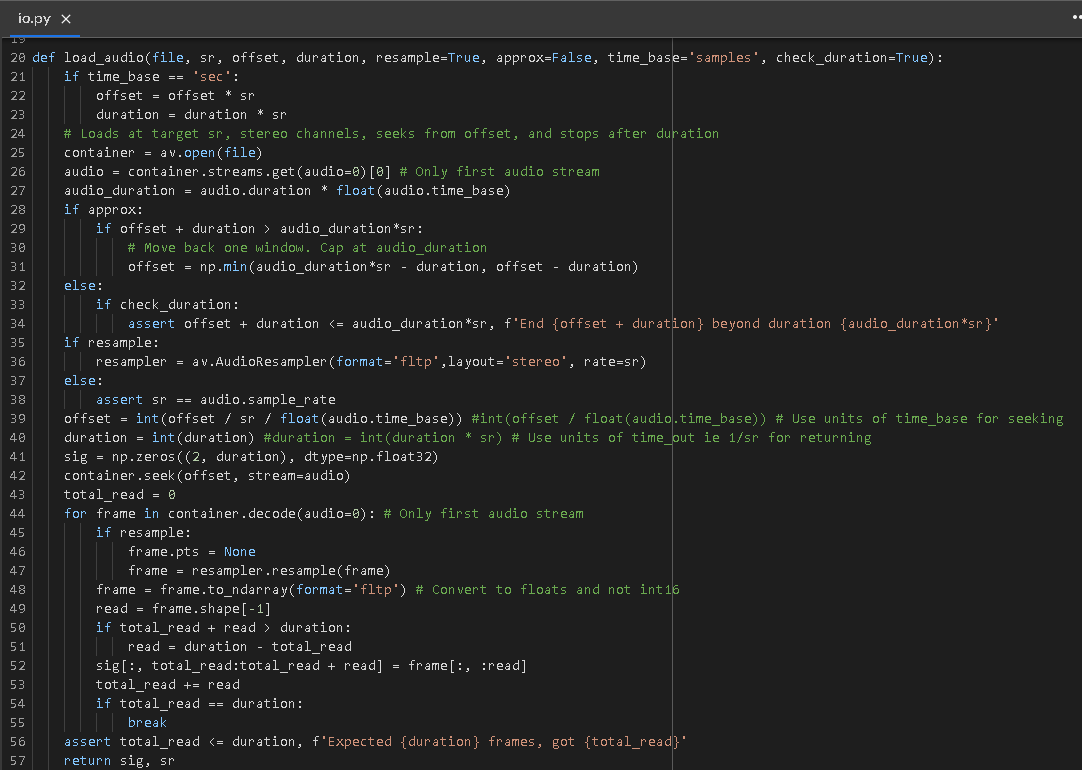



# Train VQVAE

We can now begin training our VQVAE. In this case I am training a small VQVAE without labels. 

In [ ]:
!python train.py --hps=small_vqvae --name=small_vqvae --sample_length=262144 --bs=4 --audio_files_dir=YOURDATASETFOLDER --labels=False --train --aug_shift --aug_blend

As mentioned google colab has a habit of disconnecting at around 24 hours in my experience. I reccomend halting training around that point and copying the most recent checkpoint to a folder in your google drive

In [ ]:
!cp -r /content/jukebox/logs/small_vqvae /content/drive/MyDrive/YOURCHECKPOINTFOLDER

cp: cannot stat '/content/jukebox/logs/small_vqvae': No such file or directory


# Train Prior

Now we can begin training our prior. Again, I recomend pausing training at around ~24 hours



In [ ]:
!python train.py --hps=small_vqvae,small_prior,all_fp16,cpu_ema --name=small_prior --sample_length=2097152 --bs=4 --audio_files_dir=YOURDATASETFOLDER --labels=False --train --test --aug_shift --aug_blend --restore_vqvae=YOURCHECKPOINTFOLDER/small_vqvae/checkpoint_step_xxxx.pth.tar --prior --levels=2 --level=1 --weight_decay=0.01 --save_iters=1000

Run the line below to copy the most recent checkpoint to drive

In [ ]:
!cp -r /content/jukebox/logs/small_prior /content/drive/MyDrive/YOURCHECKPOINTFOLDER

# Train Upsamplers

In [ ]:
!python train.py --hps=small_vqvae,small_upsampler,all_fp16,cpu_ema --name=small_upsampler --sample_length=262144 --bs=4 --audio_files_dir=WAV --labels=False --train --test --aug_shift --aug_blend --restore_vqvae=logs/small_vqvae/checkpoint_step_60001.pth.tar --prior --levels=2 --level=0 --weight_decay=0.01 --save_iters=1000

In [ ]:
!cp -r /content/jukebox/logs/small_upsampler /content/drive/MyDrive/YOURCHECKPOINTFOLDER

# Set Up Sampling


Some adjustments to the code are required to sample from the model. 

**Change 1**

In jukebox/jukebox/make_models.py add `'my_model_1': ("my_small_vqvae_1", "my_small_upsampler_1", "my_small_prior_1")`

on line 21 in the image below

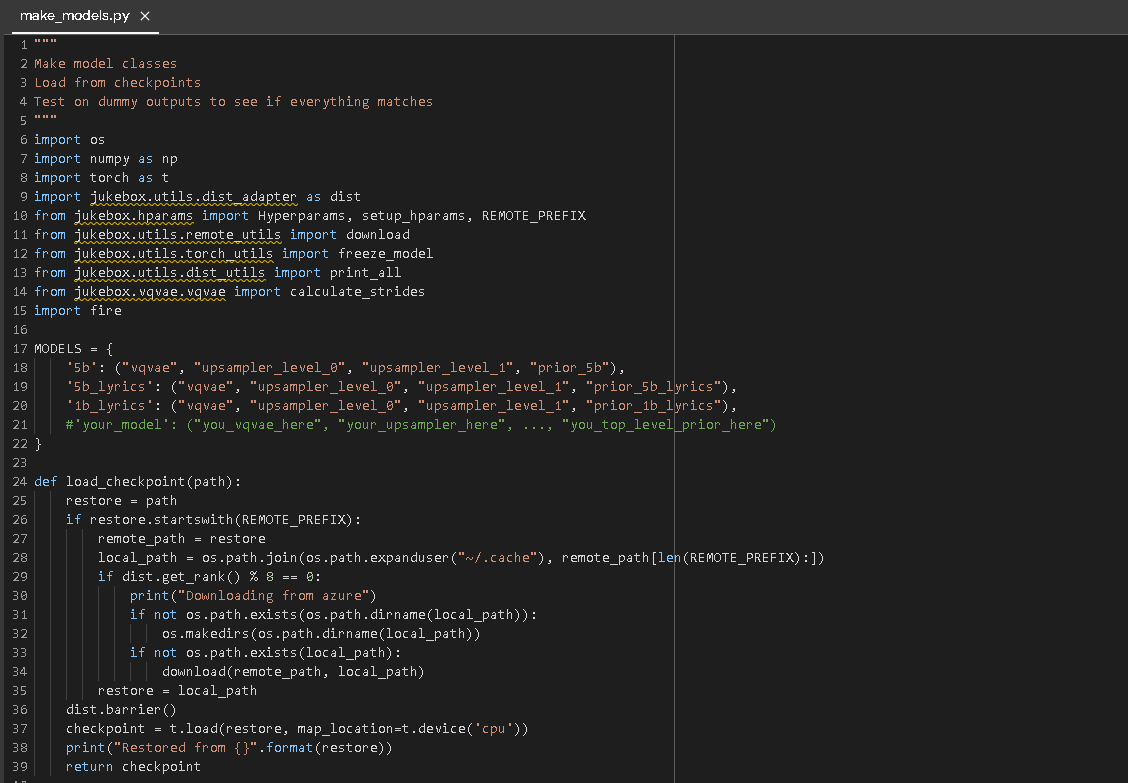

**Change 2**

In jukebox/jukebox/hparams.py add the following code. I generally choose to add it at the end of the script to maintain cleanliness.

```
my_small_vqvae_1 = Hyperparams( restore_vqvae='logs/small_vqvae/checkpoint_step_60001.pth.tar', )

my_small_vqvae_1.update(small_vqvae)

HPARAMS_REGISTRY["my_small_vqvae_1"] = my_small_vqvae_1

my_small_prior_1 = Hyperparams( 
  restore_prior='logs/small_prior/checkpoint_latest.pth.tar', 
  level=1, 
  labels=False,
  alignment_layer=47,
  alignment_head=0,
)

my_small_prior_1.update(small_prior)

HPARAMS_REGISTRY["my_small_prior_1"] = my_small_prior_1


my_small_upsampler_1 = Hyperparams(
    restore_prior='logs/small_upsampler/checkpoint_latest.pth.tar',
    level=0,
    labels=False,
)
my_small_upsampler_1.update(small_upsampler)
HPARAMS_REGISTRY["my_small_upsampler_1"] = my_small_upsampler_1
```








# Sample from Model

You can adjust the parameters in the line of code below to change the number and length of the samples generated

In [ ]:
!python sample.py --model=my_model_1 --name=my_model_1 --levels=2 --sample_length_in_seconds=120 --total_sample_length_in_seconds=180 --sr=44100 --n_samples=15 --hop_fraction=0.5,0.5,0.125

In [ ]:
!cp -r /content/jukebox/my_model_1 /content/drive/MyDrive/YOUROUTPUTDIRECTORY